# Learning outcomes
1. k-means clustering 
2. anisotropic segmentation
* anistropic is opposite to isotropic. Anisotropic is associated with direction while isotropic does not take direction to action

In [1]:
!pip install requests

In [2]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np 

import cv2 as cv
from util_func import *

## K-means clustering

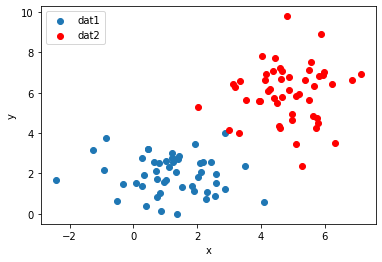

In [3]:
# sample data from bivariate Gaussian distribution (parametric)
mean1 = (1, 2)
cov1 = np.array([[2, 0], [0, 1]])
dat1 = np.random.multivariate_normal(mean1, cov1, size= 50)

mean2 = (5, 6)
cov2 = np.array([[1, 0], [0, 2]])
dat2 = np.random.multivariate_normal(mean2, cov2, size= 50)

# concatenate
data = np.concatenate((dat1, dat2), axis = 0)
Z = np.float32(data)
plt.scatter(dat1[:, 0], dat1[:, 1], label = "dat1")
plt.scatter(dat2[:, 0], dat2[:, 1], c="r", label = "dat2")
plt.xlabel("x"), plt.ylabel("y")
plt.legend()
plt.show()

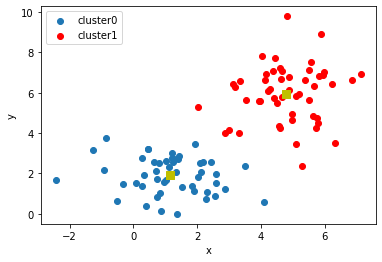

In [4]:
#apply k-means clustering (OpenCV)
criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, label, center = cv.kmeans(Z, 2, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
# ret is wcsocs, label is the cluster membership (0, 1), center 

# subset the clusters
A = Z[label.ravel()==0]
B = Z[label.ravel()==1]
plt.scatter(A[:, 0], A[:, 1], label = "cluster0")
plt.scatter(B[:, 0], B[:, 1], c="r", label = "cluster1")
plt.scatter(center[:, 0], center[:, 1], c="y", marker = "s", s = 80)
plt.xlabel("x"), plt.ylabel("y")
plt.legend()
plt.show()

### How to apply k-means clustering on image?

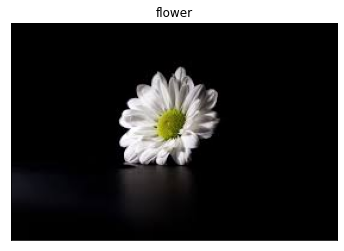

In [5]:
img = cv.imread("images/flower.jfif")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt_img(img_rgb, "flower")

In [6]:
def k_means_clust(img, K, max_iter = 10, eps=1.0, attempts = 10, flag = cv.KMEANS_PP_CENTERS):
    """Args:
    img:3-channel color image
    K user-defined number of cluster
    By default, max_iter = 10, eps = 1, repetitions = 10, k-means++"""
    # reshape and cast
    img = img.reshape((-1, 3))
    img = np.float32(img)
    criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, max_iter, eps)
    return cv.kmeans(img, K, None, criteria, attempts, flag)
    



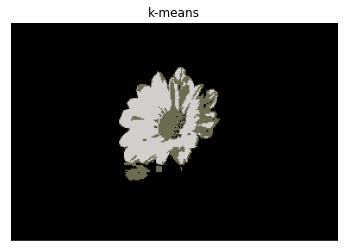

In [7]:
ret, label, center = k_means_clust(img_rgb, 3)
# cast the center, index the center with the label, reshape to original image
# dimension
center = np.uint8(center)
res = center[label.ravel()]
quant = res.reshape(img_rgb.shape)

plt_img(quant, "k-means")

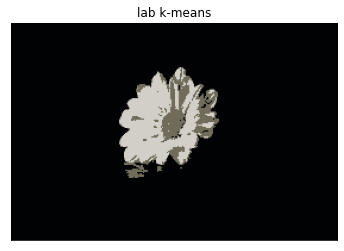

In [8]:
# recommend the lab color space: perceptual uniformity
img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)
ret, label, center = k_means_clust(img_lab, 3)

# cast the center, index the center with the label, reshape to original image
# dimension
center = np.uint8(center)
res = center[label.ravel()]
quant = res.reshape(img_rgb.shape)

# change to RGB
quant_rgb = cv.cvtColor(quant, cv.COLOR_Lab2RGB)
plt_img(quant_rgb, "lab k-means")

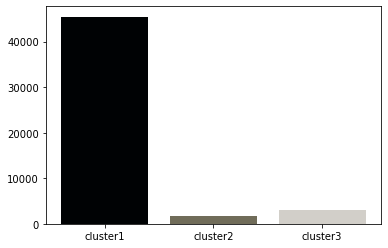

In [9]:
#distribution cluster (bar plot)
centroids, counts = np.unique(res, axis = 0, return_counts = True)

# plt.bar
centroids = centroids.reshape((3, 1, 3))
centroid_rgb = cv.cvtColor(centroids, cv.COLOR_Lab2RGB)
centroids_rgb = centroid_rgb.reshape((3, 3))

xlabel_name = ['cluster' + str(i) for i in range(1, 4)]

plt.bar(xlabel_name, counts, color = list(centroid_rgb/ 255))

plt.show()

In [10]:
def calcGST(inputIMG, w, method_edge = "scharr"):
    img = np.float32(inputIMG)

    # Gradient structure tensor components
    if method_edge == "scharr":
        imgDiffX = cv.Scharr(img, cv.CV_32F, 1, 0)
        imgDiffY = cv.Scharr(img, cv.CV_32F, 0, 1)
    elif method_edge == "sobel":
        imgDiffX = cv.Sobel(img, cv.CV_32F, 1, 0)
        imgDiffY = cv.Sobel(img, cv.CV_32F, 0, 1)

    imgDiffXY = cv.multiply(imgDiffX, imgDiffY)
    imgDiffXX = cv.multiply(imgDiffX, imgDiffX)
    imgDiffYY = cv.multiply(imgDiffY, imgDiffY)
    
    # Apply mean filter
    J11 = cv.boxFilter(imgDiffXX, cv.CV_32F, (w, w))
    J22 = cv.boxFilter(imgDiffYY, cv.CV_32F, (w, w))
    J12 = cv.boxFilter(imgDiffXY, cv.CV_32F, (w, w))
    # eigenvalue
    tmp1 = J11+J22
    tmp2 = J11-J22
    tmp2 = cv.multiply(tmp2, tmp2)
    tmp3 = cv.multiply(J12, J12)
    tmp4 = np.sqrt(tmp2 + 4.0*tmp3)

    lambda1 = 0.5*(tmp1+tmp4)
    lambda2 = 0.5*(tmp1 - tmp4)
    # coherency
    imgCoherencyOut = cv.divide(lambda1-lambda2, lambda1+lambda2)
    # orientation calculation
    imgOrientationOut = cv.phase(J22-J11, 2.0*J12, angleInDegrees = True)
    imgOrientationOut = 0.5*imgOrientationOut
    return imgCoherencyOut, imgOrientationOut

if you opt to perform Gaussian blurring on line 16-18 instead of mean 
filter, you might run into problem of numerical stability. The way to 
remedy the issue is by adding small constant to the first argument of line 34.

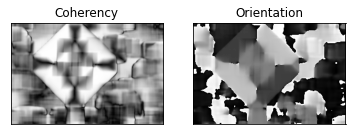

In [11]:
# visualize the coherency and orientation map 
img = cv.imread("images/traffic_sign.jfif")
blur = cv.GaussianBlur(img, (5, 5), 0)
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

W = 25
imgCoherency, imgOrientation = calcGST(gray, W)

imgCoherency_norm = cv.normalize(imgCoherency, None, alpha = 0, beta= 1, norm_type = cv.NORM_MINMAX, dtype = cv.CV_32F)
imgOrientation_norm = cv.normalize(imgOrientation, None, alpha = 0, beta= 1, norm_type = cv.NORM_MINMAX, dtype = cv.CV_32F)
plt.subplot(121), plt_img(imgCoherency_norm, "Coherency")
plt.subplot(122), plt_img(imgOrientation_norm, "Orientation")
plt.show()


In [12]:
# trackbars
def nothing(x):
    pass
wn = "anisotropic segmentation"

cv.namedWindow(wn, cv.WINDOW_NORMAL | cv.WINDOW_FREERATIO)
cv.createTrackbar("Coherency Threshold 1", wn, 50, 100, nothing)
cv.createTrackbar("Coherency Threshold 2", wn, 70, 100, nothing)
cv.createTrackbar("Orientation Threshold 1", wn, 70, 180, nothing)
cv.createTrackbar("Orientation Threshold 2", wn, 100, 180, nothing)

img = cv.imread("images/road.jpg")
blur = cv.GaussianBlur(img, (5, 5), 0)
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

W = 25
imgCoherency, imgOrientation = calcGST(gray, W)

while True:
    # get the trackbar value
    th_C_1 = cv.getTrackbarPos("Coherency Threshold 1", wn) * 0.01
    th_C_2 = cv.getTrackbarPos("Coherency Threshold 2", wn) * 0.01
    th_Or_1 = cv.getTrackbarPos("Orientation Threshold 1", wn) 
    th_Or_2 = cv.getTrackbarPos("Orientation Threshold 2", wn) 
    
    # thresholding 
    imgBin_C_1 = cv.threshold(imgCoherency, th_C_1, 255, cv.THRESH_BINARY)[1]
    imgBin_C_2 = cv.threshold(imgCoherency, th_C_2, 255, cv.THRESH_BINARY_INV)[1]
    imgBin_Or_1 = cv.threshold(imgOrientation, th_Or_1, 255, cv.THRESH_BINARY)[1]
    imgBin_Or_2 = cv.threshold(imgOrientation, th_Or_2, 255, cv.THRESH_BINARY_INV)[1]

    # bitwise_and
    imgBin_C = cv.bitwise_and(imgBin_C_1, imgBin_C_2)
    imgBin_Or = cv.bitwise_and(imgBin_Or_1, imgBin_Or_2)
    # Final segmentation mask
    imgBin = cv.bitwise_and(imgBin_C, imgBin_Or)
    
    mask = imgBin != 0
    res = img*(mask[:, :, None].astype(np.uint8))
    cv.imshow(wn, res)
    cv.imshow("segmentation mask", imgBin)
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
    
cv.destroyAllWindows()




## Watershed
* Topo surface: edge map
* marker: morpholofical gradient and thresholding

In [13]:
img = cv.imread("images/traffic_sign.jfif")
blur = cv.GaussianBlur(img, (5, 5), 0)
blur = cv.pyrMeanShiftFiltering(blur, 15, 20, maxLevel = 2)

show_img("mean shift", blur)

In [14]:
# grayscale 
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)
# morphological gradient 
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11))
loc_grad = cv.morphologyEx(gray, cv.MORPH_GRADIENT, kernel, iterations = 2)

show_img("gradient", loc_grad)

In [15]:
from skimage.segmentation import watershed
from scipy import ndimage as ndi

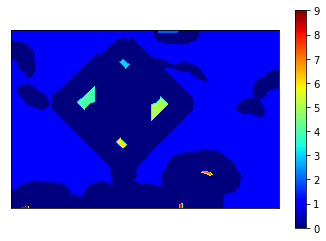

In [16]:
# threshold produce boolean matrix
th = loc_grad < 80

# connected component labeling
s = np.ones((3, 3), dtype = int)
marker = ndi.label(th, structure = s)[0]

plt.imshow(marker, cmap = plt.cm.jet)
plt.colorbar()
plt.xticks([]), plt.yticks([])
plt.show()

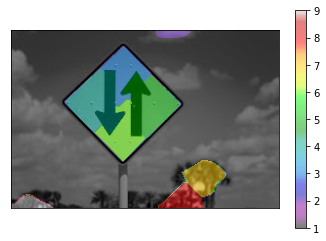

In [17]:
# topo surface 
edge = cv.Canny(gray, 250, 500)
labels = watershed(edge, marker)

# grab the original grayscale
gray_ori = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(gray_ori, cmap = "gray")
plt.imshow(labels, cmap = plt.cm.nipy_spectral, alpha = 0.5)
plt.colorbar()
plt.xticks([]), plt.yticks([])
plt.show()

In [18]:
np.unique(labels, return_counts = True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([40736,   279,  1234,  2325,  2295,  1270,  1066,   736,   384],
       dtype=int64))

In [19]:
# assumption: background is of the majority (has the largest number pixels)
label_vec, counts = np.unique(labels, return_counts = True)
label_bg = label_vec[np.argmax(counts)]
# create a mask(all white except background)
mask = 255 * np.ones(labels.shape, dtype = np.uint8)
mask[labels==label_bg] = 0

# the above mask is uint8, binary, apply find contour
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# assumption: Largest contour is the traffic sign 
contour = sorted(contours, key = cv.contourArea, reverse = True)[0]

img_copy = img.copy()
cv.drawContours(img_copy, [contour], -1, (0, 255, 0), 2)

show_img("contour", img_copy)

In [20]:
np.unique(labels, return_counts = True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([40736,   279,  1234,  2325,  2295,  1270,  1066,   736,   384],
       dtype=int64))

In [21]:
# draw bounding box 
x, y, w, h = cv.boundingRect(contour)
img_copy = img.copy()
cv.rectangle(img_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
show_img("bounding box", img_copy)

In [22]:
img = cv.imread("images/traffic_sign1.jpg")
blur = cv.GaussianBlur(img, (5, 5), 0)

show_img("blur", blur)

In [23]:
img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)

#kmeans
ret, label, center = k_means_clust(img_lab, 10)

center = np.uint8(center)
res = center[label.flatten()]
quant = res.reshape(img_lab.shape)

quant_bgr = cv.cvtColor(quant, cv.COLOR_Lab2BGR)

show_img("quant", quant_bgr)

In [24]:
from skimage.feature import peak_local_max

In [25]:
np.unique(labels, return_counts = True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([40736,   279,  1234,  2325,  2295,  1270,  1066,   736,   384],
       dtype=int64))

In [26]:
# grayscale 
gray = cv.cvtColor(quant_bgr, cv.COLOR_BGR2GRAY)

#Otsu thresholding
th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

# opening
kernel = np.ones((3, 3), dtype = np.uint8)
opening = cv.morphologyEx(th, cv.MORPH_OPEN, kernel, iterations = 3)

# distance transform
dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 3)

# find the local maxima coordinates
coords = peak_local_max(dist_transform, footprint = np.ones((100,100)), labels = opening)

mask = np.zeros(dist_transform.shape, dtype = bool)
mask[tuple(coords.T)] = True
marker = ndi.label(mask)[0]


In [27]:
np.unique(labels, return_counts = True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([40736,   279,  1234,  2325,  2295,  1270,  1066,   736,   384],
       dtype=int64))

In [28]:
labels = watershed(-dist_transform, marker, mask = opening)

np.unique(labels, return_counts = True)


(array([0, 1, 2, 3, 4]),
 array([39445,  6484,  1501,   653,  2242], dtype=int64))

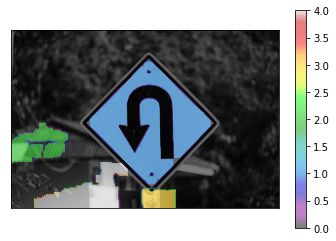

In [29]:
# grab the original grayscale
gray_ori = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(gray_ori, cmap = "gray")
plt.imshow(labels, cmap = plt.cm.nipy_spectral, alpha = 0.5)
plt.colorbar()
plt.xticks([]), plt.yticks([])
plt.show()

In [30]:
# assumption: background is of the majority (has the largest number pixels)
label_vec, counts = np.unique(labels, return_counts = True)
label_bg = label_vec[np.argmax(counts)]
# create a mask(all white except background)
mask = 255 * np.ones(labels.shape, dtype = np.uint8)
mask[labels==label_bg] = 0

# the above mask is uint8, binary, apply find contour
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# assumption: Largest contour is the traffic sign 
contour = sorted(contours, key = cv.contourArea, reverse = True)[0]

img_copy = img.copy()
cv.drawContours(img_copy, [contour], -1, (0, 255, 0), 2)

show_img("contour", img_copy)

In [31]:
# draw bounding box 
x, y, w, h = cv.boundingRect(contour)
img_copy = img.copy()
cv.rectangle(img_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
show_img("bounding box", img_copy)

## Exercise



1. Apply k-means clustering on 'zebra.jfif' to segment out the zebra.
- You are required to determine the optimal k by plotting the within cluster sum of squares vs number of
clusters (2-10).
- Apply the clustering method on 3 color spaces: BGR, HSV and LAB. Compare the results obtained

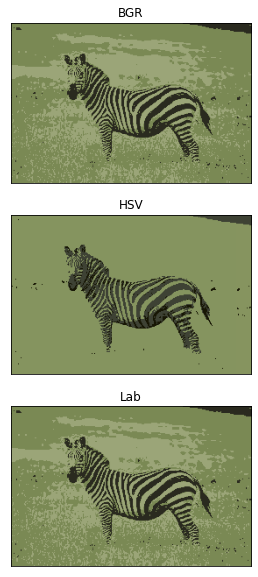

In [32]:
# Image on BGR
img = cv.imread("images/zebra.jfif")
plt.figure(figsize = (15,10))
ret, label, center = k_means_clust(img, 3)

center = np.uint8(center) 
res = center[label.flatten()]
quant = res.reshape(img.shape)
quant_bgr = cv.cvtColor(quant, cv.COLOR_BGR2RGB)
plt.subplot(311), plt_img(quant_bgr, "BGR")

# Image on HSV
img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
ret, label, center = k_means_clust(img_hsv, 3)

center = np.uint8(center) 
res = center[label.flatten()]
quant2 = res.reshape(img.shape)
quant_hsv = cv.cvtColor(quant2, cv.COLOR_HSV2RGB)
plt.subplot(312), plt_img(quant_hsv, "HSV")

# Image on Lab
img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)
ret, label, center = k_means_clust(img_lab, 3)

center = np.uint8(center) 
res = center[label.flatten()]
quant3 = res.reshape(img.shape)
quant_lab = cv.cvtColor(quant3, cv.COLOR_Lab2RGB)
plt.subplot(313), plt_img(quant_bgr, "Lab")

plt.show()